In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [15]:
# Load the data
df = pd.read_csv('acs-f2-dataset 1.csv')


In [16]:
# Convert 'time' to datetime
df['time'] = pd.to_datetime(df['time'])

In [17]:
# Convert categorical labels to numeric
le = LabelEncoder()
df['equipment'] = le.fit_transform(df['equipment'])

In [18]:
# Split features and labels
X = df.drop('equipment', axis=1)
y = df['equipment']

In [19]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns=['time']))


In [20]:
# Convert labels to one-hot encoding
y_encoded = to_categorical(y)

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the model (now with more neurons to account for additional features)
# Define the model (now with more neurons to account for additional features)
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(y_encoded.shape[1], activation='softmax')
])

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

c:\Users\honey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.5, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

Epoch 1/500
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3160 - loss: 2.0215 - val_accuracy: 0.4793 - val_loss: 1.4609
Epoch 2/500
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4560 - loss: 1.5204 - val_accuracy: 0.5441 - val_loss: 1.2639
Epoch 3/500
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5104 - loss: 1.3623 - val_accuracy: 0.5965 - val_loss: 1.1376
Epoch 4/500
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5496 - loss: 1.2522 - val_accuracy: 0.6185 - val_loss: 1.0756
Epoch 5/500
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5743 - loss: 1.1804 - val_accuracy: 0.6468 - val_loss: 0.9964
Epoch 6/500
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5913 - loss: 1.1213 - val_accuracy: 0.6700 - val_loss: 0.9460
Epoch 7/500
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6067 - loss: 1.0845 - val_accuracy: 0.6799 - val_loss: 0.9091
Epoch 8/500
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6186 - loss: 1

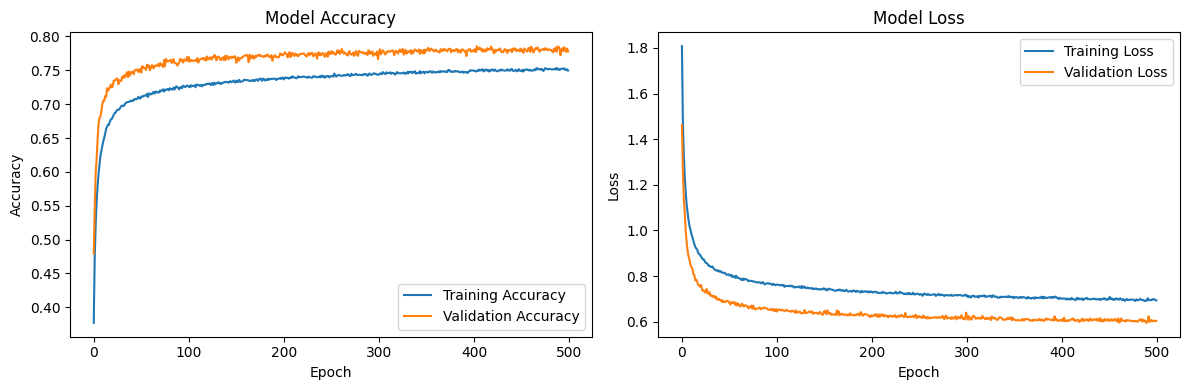

In [24]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


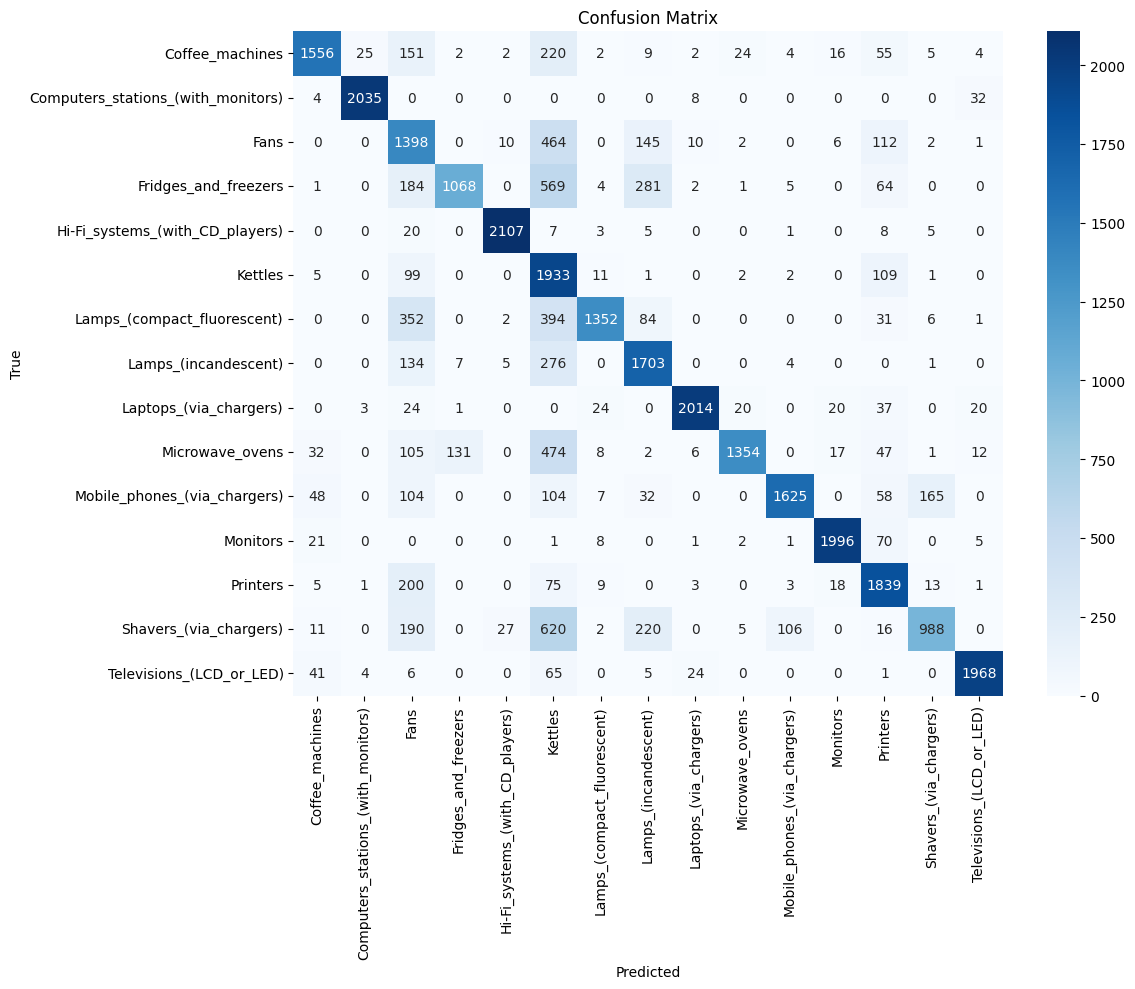

In [25]:

# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [26]:
# Function to predict appliance and probabilities
def predict_appliance(electrical_readings, hour, day_of_week, month):
    # Combine electrical readings with time features
    input_data = np.concatenate([electrical_readings, [hour, day_of_week, month]])
    
    # Ensure the input is a 2D array
    input_data = input_data.reshape(1, -1)
    
    # Scale the input
    scaled_input = scaler.transform(input_data)
    
    # Make prediction
    probabilities = model.predict(scaled_input)[0]
    predicted_class = le.inverse_transform([np.argmax(probabilities)])[0]
    
    return predicted_class, probabilities


In [27]:
# Example usage
example_reading = np.array([50.0, 340, 111.284, -40.89, 0.533, 224.038])
example_hour = 12
example_day_of_week = 2  # 0 = Monday, 6 = Sunday
example_month = 11

predicted_appliance, probabilities = predict_appliance(example_reading, example_hour, example_day_of_week, example_month)

print(f"Predicted appliance: {predicted_appliance}")
print("Probabilities for each appliance:")
for appliance, prob in zip(le.classes_, probabilities):
    print(f"{appliance}: {prob:.4f}")


c:\Users\honey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 9 features, but StandardScaler is expecting 6 features as input.

In [ ]:
# Plot probabilities
plt.figure(figsize=(10, 6))
sns.barplot(x=le.classes_, y=probabilities)
plt.title('Appliance Prediction Probabilities')
plt.xlabel('Appliance')
plt.ylabel('Probability')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [12]:

joblib.dump(scaler, 'scaler.pkl')

model.save('appliance_recogniser#1.keras')
